The data we will use comes from the [Computing in Cardiology (CinC) Challenge 2017](https://physionet.org/content/challenge-2017/1.0.0/) dataset hosted on Physionet.

The dataset contains thousands of short ECG snippets (30s - 60s) from the AliveCor mobile ECG monitor. The original challenge was to build a 4-class classifier for sinus rhythm, atrial fibrillation, alternative rhythm, and noisy record. We will throw out the noisy records and build a two-class classifier distinguishing between sinus rhythm and another rhythm (atrial fibrillation included).

# Data Exploration

Let's examine our ECG dataset

## Imports

In [1]:
import glob

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

## Load Reference Data

In [2]:
ref = pd.read_csv('cinc/REFERENCE.csv')

The reference data is a flat table that tells us what rhythm each record is in. `N` for normal sinus rhythm and `O` for other rhythm. Our task will be to classify ECG signals into these two classes

In [3]:
ref.head()

,record,rhythm
0,A00001,N
1,A00002,N
2,A00003,N
3,A00004,O
4,A00005,O


Class ratio

We have roughly 1.5x more sinus rhythm data than other.

In [4]:
ref.rhythm.value_counts()

N    4529
O    2887
Name: rhythm, dtype: int64

The sampling rate for this dataset is 300 Hz.

In [5]:
fs = 300

## Load Raw ECG Data + QRS locations

The data is stored in `npz` files. We are given both the raw ECG data as well as the QRS complex locations.

In [6]:
data_dir = 'cinc/'
files = sorted(glob.glob(data_dir + '*.npz'))
ecgs, qrs_inds = [], []
for f in files:
    with np.load(f) as npz:
        ecgs.append(npz['ecg'])
        qrs_inds.append(npz['qrs'])

Let's take a look at how long each ECG record is.

Text(0.5, 1.0, 'Length of ECG records')

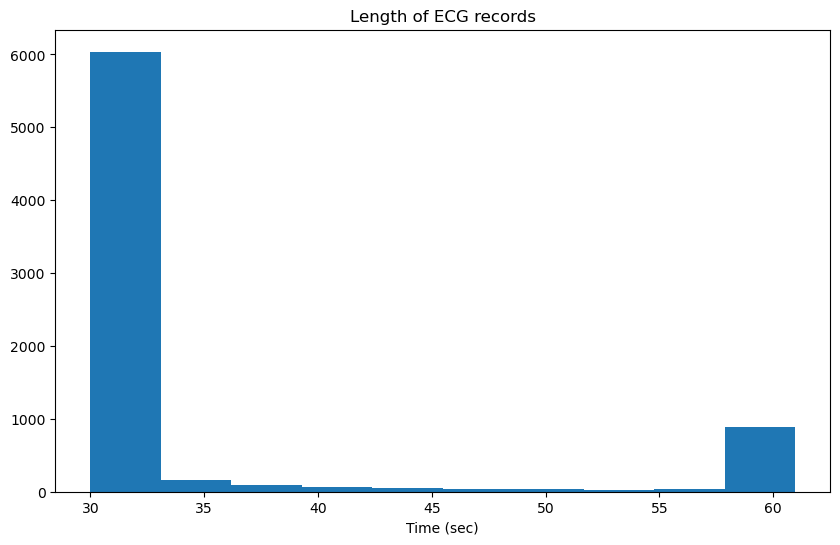

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(np.array(list(map(len, ecgs))) / fs);
plt.xlabel('Time (sec)')
plt.title('Length of ECG records')

Now let's look at the raw ECG data plotted with the QRS locations

### Normal sinus rhythm

By looking at sinus rhythm data we can get a sense of the noise level in the sensor without dealing with rhythm-induced artifacts.

Text(0.5, 1.0, 'Sinus Rhythm')

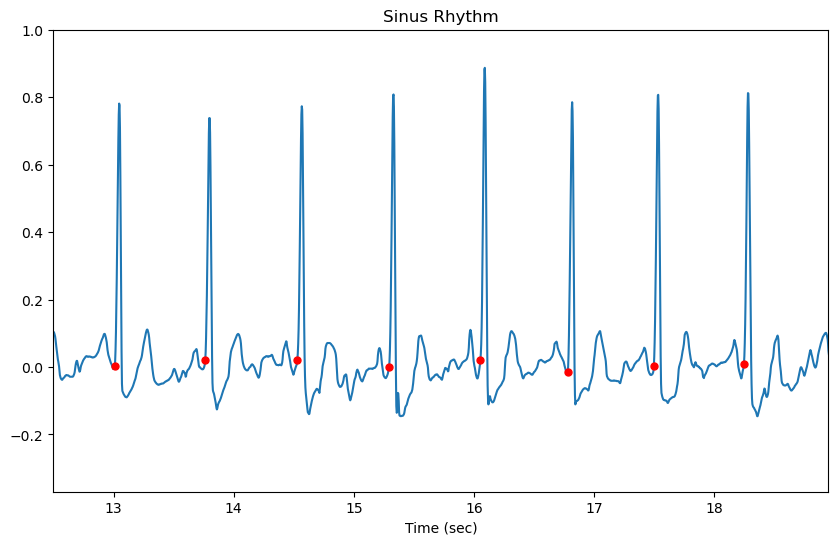

In [8]:
plt.figure(figsize=(10, 6))
ecg, qrs = ecgs[0], qrs_inds[0]
ts = np.arange(len(ecg)) / fs
plt.plot(ts, ecg)
plt.plot(ts[qrs], ecg[qrs], 'r.', ms=10, label='QRS Detections')
plt.xlim((12.5, 18.95))
plt.xlabel('Time (sec)')
plt.ylim((-.37, 1))
plt.title('Sinus Rhythm')

### Noisy sinus rhythm

Sometimes our ECG rhythm will be interrupted by transient noise artifacts, most likely caused by user error or motion artifact. Even in the presence of motion, the QRS detection algorithm still finds QRS complexes. In the presence of noise, there surely might be some error in the QRS detections.

Text(0.5, 1.0, 'Noisy Sinus Rhythm')

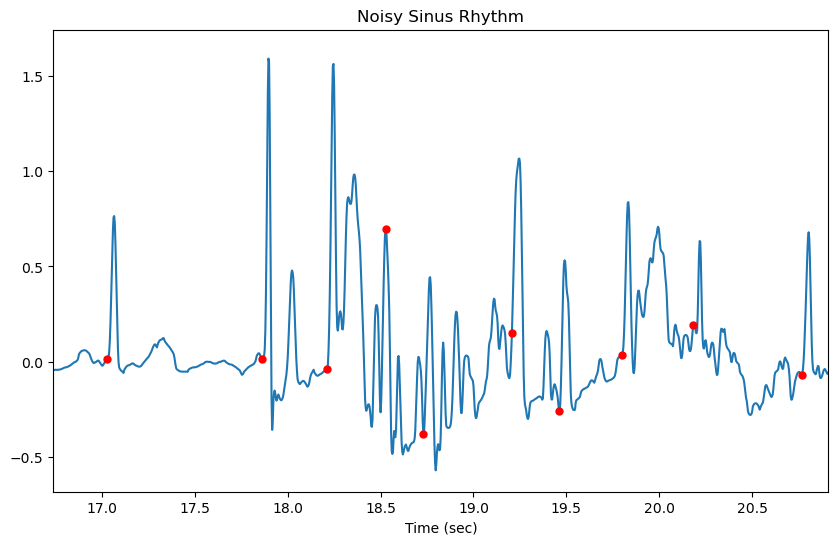

In [9]:
plt.figure(figsize=(10, 6))
ecg, qrs = ecgs[1], qrs_inds[1]
ts = np.arange(len(ecg)) / fs
plt.plot(ts, ecg)
plt.plot(ts[qrs], ecg[qrs], 'r.', ms=10, label='QRS Detections')
plt.xlim((16.74, 20.91))
plt.xlabel('Time (sec)')
plt.ylim((-0.68, 1.74))
plt.title('Noisy Sinus Rhythm')

### Atrial Fibrillation

This is an example of an atrial fibrillation ECG. Notice the irregularity in the QRS complex times. This will be the source of most of our features in the algorithm.

Text(0.5, 1.0, 'AF Rhythm')

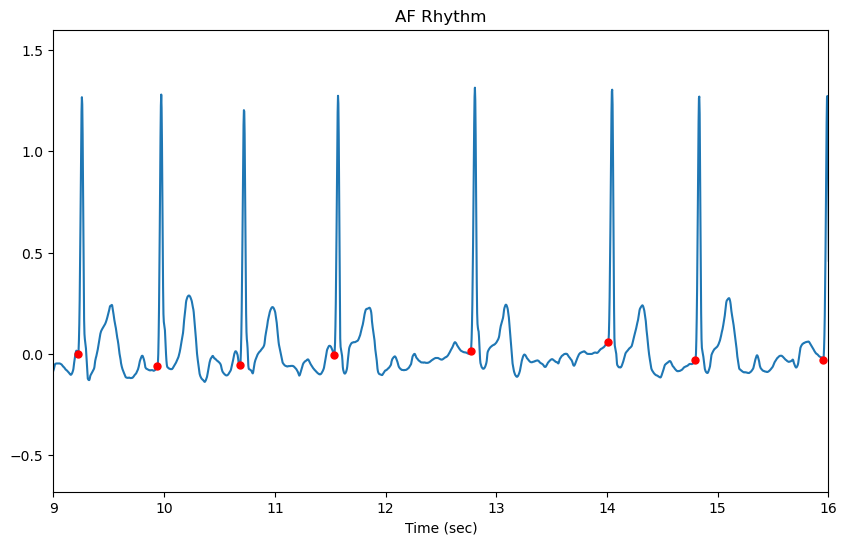

In [10]:
plt.figure(figsize=(10, 6))
ecg, qrs = ecgs[3], qrs_inds[3]
ts = np.arange(len(ecg)) / fs
plt.plot(ts, ecg)
plt.plot(ts[qrs], ecg[qrs], 'r.', ms=10, label='QRS Detections')
plt.xlim((9, 16))
plt.xlabel('Time (sec)')
plt.ylim((-0.68, 1.6))
plt.title('AF Rhythm')

From exploring our data, we see that we have 1.5x more sinus rhythm records than other rhythm records. Most of the records are 30 seconds long; some are 60 seconds long, and a few are somewhere in between.

We plot the data and visualize the QRS complex detections provided in the dataset. The QRS complex detector still detects QRS complexes during periods of high noise, but these detections are suspect.